In [1]:
import glob
#!pip install numpy==1.21.1
import numpy as numpy
%config Completer.use_jedi = False
import _pickle as cPickle

In [2]:
from scipy.stats import skew, kurtosis
def uttr_LLD (uttr_embd, feat):
    uttr_mean = uttr_embd.mean(axis=0)
    uttr_std = uttr_embd.std(axis=0)
    uttr_skw = skew(uttr_embd, axis=0)
    uttr_kur = kurtosis(uttr_embd, axis=0)
    #print(uttr_embd.shape)
    #print(uttr_mean.shape, uttr_std.shape, uttr_skw.shape, uttr_kur.shape)
    if feat == 'mean':
        LLD_feat= numpy.hstack(uttr_mean)#, uttr_skw, uttr_kur))
    if feat == 'mean_std':
        LLD_feat= numpy.hstack((uttr_mean, uttr_std))#, uttr_skw, uttr_kur))
    if feat == 'all':
        LLD_feat= numpy.hstack((uttr_mean, uttr_std, uttr_skw, uttr_kur))
    
    LLD_feat = LLD_feat.reshape(1,LLD_feat.shape[0])
    return LLD_feat

In [3]:
def Session_LLD_features(embd_data,feat):
    wav_nom =[]
    LLD_feat = []
    Labels = []
    for uttr in embd_data:
        uttr_nom = uttr[0] 
        uttr_label = int(numpy.mean(uttr[1]))
        uttr_embd = uttr[2][:,0:30] # static_features= uttr[0][:,0:10] ; delta_features= uttr[0][:,10:20] ; delta_delta_features= uttr[0][:,20:30]
        LLD_uttr_level = uttr_LLD(uttr_embd, feat) # fetching utterance level LLD features
        wav_nom.append (uttr_nom)
        Labels.append(uttr_label)
        LLD_feat.append(LLD_uttr_level)
    wav_nom= numpy.array(wav_nom)
    LLD_feat = numpy.vstack(numpy.array(LLD_feat))
    Labels = numpy.array(Labels)
    return (wav_nom.reshape(wav_nom.shape[0],1), LLD_feat, Labels.reshape(Labels.shape[0],1))

In [4]:
def get_test_data (Set, Embedding_type,model_Ids,test_Ids,feat):
    # "/idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd/f1/S_D_DD_Session_1.list.pickle"
    test_embed= "idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd/"+model_Ids+"/S_D_DD_"+test_Ids[0]+".list.pickle"
    with open(r'/'+test_embed, "rb") as input_file:
            embd_data = cPickle.load(input_file)
    print("Test Features:\n")
    print("Session ID:  {} ".format(test_Ids[0]))
    print("Total utterances:  {}\n".format(len(embd_data)))
    test_wav_nom, test_LLD_feat, test_Labels = Session_LLD_features(embd_data,feat)
    print(test_wav_nom.shape, test_LLD_feat.shape, test_Labels.shape)
    return test_wav_nom, test_LLD_feat, test_Labels

In [5]:
def get_train_data (Set, Embedding_type,model_Ids, train_Ids,feat):
    All_train_data =[]
    print("Train Data:\n")
    for sessions in train_Ids:
        train_embed= "idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd/"+model_Ids+"/S_D_DD_"+sessions+".list.pickle"
        with open(r'/'+train_embed, "rb") as input_file:
                embd_data = cPickle.load(input_file)
        print("Session ID:  {} ".format(sessions))
        print("Total utterances:  {}\n".format(len(embd_data)))
        All_train_data.append (embd_data)

    all_train_nom = []
    all_train_lab = []
    all_train_feat =[]
    for sess_wise_data in All_train_data:
        train_wav_nom, train_LLD_feat, train_Labels = Session_LLD_features(sess_wise_data,feat)
        print(train_wav_nom.shape, train_LLD_feat.shape, train_Labels.shape)
        all_train_nom.append(train_wav_nom)
        all_train_lab.append(train_Labels)
        all_train_feat.append(train_LLD_feat)

    all_train_nom = numpy.vstack(all_train_nom) 
    all_train_lab = numpy.vstack(all_train_lab)
    all_train_feat = numpy.vstack(all_train_feat)

    print("\nFinal train feature shape = ", all_train_feat.shape)
    print("\nFinal train label shape = ", all_train_lab.shape)
    print("\nFinal train wav_nom shape = ", all_train_nom.shape)

    values, counts = numpy.unique(all_train_lab[:,0], return_counts=True)
    print(values)
    print(counts)
    return all_train_feat, all_train_lab

In [11]:
from sklearn import svm
def SVM_Score_generation (feats,model_Ids,Set, Embedding_type,all_train_feat, all_train_lab,test_wav_nom, test_LLD_feat, test_Labels):
    clf = svm.SVC(kernel='rbf', probability=True)
    clf.fit(all_train_feat, all_train_lab[:,0])
    predict_class= numpy.argmax(clf.predict_proba(test_LLD_feat),axis=1)
    give_posterior = clf.predict_proba(test_LLD_feat)
    sav_path= "/idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd"+"/"+model_Ids+"/"
    with open(sav_path+"RBF_S_D_DD_Final"+test_Ids[0]+"_SVM_"+feats+"_score.txt", 'a') as f:
        for i in range (0, give_posterior.shape[0]):
            f.write("%s %s %s\n" %(test_wav_nom[i][0],test_Labels[i][0],give_posterior[i]))
    f.close()

In [12]:
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

model = ['f1','f2', 'f3', 'f4', 'f5']
Sessions_Ids = ['Session_1', 'Session_2', 'Session_3', 'Session_4', 'Session_5']

Set = 'Set_2' # Set_0 ; Set_2
Embedding_type = 'Embeddings_Relu' # Embeddings_Relu
feat = 'all' # mean , mean_std , all

for m in range (0,5):
    model_Ids = model[m]
    if model_Ids == 'f1':
        test_Ids = ['Session_5']
        train_Ids = Diff(Sessions_Ids, test_Ids)
    if model_Ids == 'f2':
        test_Ids = ['Session_4']
        train_Ids = Diff(Sessions_Ids, test_Ids)
    if model_Ids == 'f3':
        test_Ids = ['Session_3']
        train_Ids = Diff(Sessions_Ids, test_Ids)
    if model_Ids == 'f4':
        test_Ids = ['Session_2']
        train_Ids = Diff(Sessions_Ids, test_Ids)
    if model_Ids == 'f5':
        test_Ids = ['Session_1']
        train_Ids = Diff(Sessions_Ids, test_Ids)
    print("Model ID :{}".format(model_Ids))
    print("Test Session: {}".format(test_Ids))
    print("Train Session: {}".format(train_Ids))

    test_wav_nom, test_LLD_feat, test_Labels =  get_test_data (Set, Embedding_type,model_Ids,test_Ids,feat)
    all_train_feat, all_train_lab = get_train_data (Set, Embedding_type,model_Ids, train_Ids,feat)
    SVM_Score_generation (feat,model_Ids,Set, Embedding_type,all_train_feat, all_train_lab,test_wav_nom, test_LLD_feat, test_Labels)
    print("Model {} complete.... \n\n\n".format(model_Ids))

Model ID :f1
Test Session: ['Session_5']
Train Session: ['Session_1', 'Session_2', 'Session_3', 'Session_4']
Test Features:

Session ID:  Session_5 
Total utterances:  1107

(1107, 1) (1107, 120) (1107, 1)
Train Data:

Session ID:  Session_1 
Total utterances:  1106

Session ID:  Session_2 
Total utterances:  1106

Session ID:  Session_3 
Total utterances:  1106

Session ID:  Session_4 
Total utterances:  1106

(1106, 1) (1106, 120) (1106, 1)
(1106, 1) (1106, 120) (1106, 1)
(1106, 1) (1106, 120) (1106, 1)
(1106, 1) (1106, 120) (1106, 1)

Final train feature shape =  (4424, 120)

Final train label shape =  (4424, 1)

Final train wav_nom shape =  (4424, 1)
[0 1 2 3]
[ 892 1301 1359  872]


KeyboardInterrupt: 

In [16]:
# from sklearn.metrics import classification_report
# target_names = ['anger', 'happy', 'neutral', 'sad']

# print(classification_report(test_Labels[:,0],predict_class, target_names=target_names))

# Report Generation:

In [13]:
def generate_ypred(score_list):
    '''''
    labels :

    anger -->0
    happy -->1
    excited -->1
    neutral -->2
    sad --> 3 

    we club happy and excited as happy
    '''''

    tru_label =[]
    pred_label =[]
    for item in score_list:
        ground_truth = int(item.split(' ')[1])
        start = '['  
        end = ']'
        strin = item
        req_string = strin[strin.find(start)+len(start): strin.rfind(end)]
        req_str_list = req_string.split(' ')
        distribution = []
        for element in req_str_list:
            try:
                distribution.append(float(element))
            except:
                continue
        #print(ground_truth, distribution)
        tru_label.append(ground_truth)
        pred_label.append(numpy.argmax(distribution))
    return tru_label , pred_label

In [14]:
#"/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/Embeddings/"+model_Ids+"/"
Set = 'Set_2' # Set_0 ; Set_2
Embedding_type = 'Embeddings_Relu' # Embeddings_Relu
feat = 'all'
#"/idiap/temp/tpurohit/ML_Project2/f1/FinalSession_5_SVM_all_score.txt"
t_lab_lst=[]
p_lab_lst=[]
id_lst = ['f1', 'f2', 'f3', 'f4', 'f5']
for exp_id in id_lst: 
    #exp_id ='f5'  #f1,f2,f3,f4,f5
    session_id = {'f1':'Session_5', 'f2':'Session_4','f3':'Session_3','f4':'Session_2','f5':'Session_1'}
    print(session_id[exp_id])
    #"/idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd/f1/S_FinalSession_5_SVM_all_score.txt"
    path_score = "/idiap/temp/tpurohit/IEMOCAP-SD/Delta_Embd"+"/"+exp_id+"/RBF_S_D_DD_Final"+session_id[exp_id]+"_SVM_"+feat+"_score.txt"
    if Embedding_type== 'Embeddings':
        title = "IEMOCAP:"+Set+" SVM Exp-2 Dense_"+feat+"_Features"
    if Embedding_type== 'Embeddings_Relu':
        title = "IEMOCAP:"+Set+" SVM Exp-2 RELU_"+feat+"_Features"
    f = open(path_score,"r")
    score= f.read()
    score_list = score.split("\n")
    del score_list[-1]
    print(len(score_list))
    tru_lab, pre_lab = generate_ypred(score_list)
    t_lab_lst.append(tru_lab)
    p_lab_lst.append(pre_lab)
    

tru_lab = t_lab_lst[0]+t_lab_lst[1]+t_lab_lst[2]+t_lab_lst[3]+t_lab_lst[4]
pre_lab = p_lab_lst[0]+p_lab_lst[1]+p_lab_lst[2]+p_lab_lst[3]+p_lab_lst[4]
print(len(tru_lab),len(pre_lab))

Session_5
1107
Session_4
1106
Session_3
1106
Session_2
1106
Session_1
1106
5531 5531


In [10]:
### Static  ####
from sklearn.metrics import classification_report
target_names = ['anger', 'happy', 'neutral', 'sad']

print(classification_report(tru_lab, pre_lab, target_names=target_names, digits=4)) #digits=4

              precision    recall  f1-score   support

       anger     0.7464    0.6990    0.7219      1103
       happy     0.6470    0.6687    0.6576      1636
     neutral     0.6465    0.6511    0.6488      1708
         sad     0.6716    0.6734    0.6725      1084

    accuracy                         0.6702      5531
   macro avg     0.6779    0.6730    0.6752      5531
weighted avg     0.6715    0.6702    0.6706      5531



In [11]:
###  Delta ####
from sklearn.metrics import classification_report
target_names = ['anger', 'happy', 'neutral', 'sad']

print(classification_report(tru_lab, pre_lab, target_names=target_names, digits=4)) #digits=4

              precision    recall  f1-score   support

       anger     0.6787    0.6818    0.6802      1103
       happy     0.5862    0.6070    0.5964      1636
     neutral     0.5942    0.5925    0.5934      1708
         sad     0.6209    0.5876    0.6038      1084

    accuracy                         0.6136      5531
   macro avg     0.6200    0.6172    0.6184      5531
weighted avg     0.6139    0.6136    0.6136      5531



In [10]:
### Static + Delta  ####
from sklearn.metrics import classification_report
target_names = ['anger', 'happy', 'neutral', 'sad']

print(classification_report(tru_lab, pre_lab, target_names=target_names, digits=4)) #digits=4

              precision    recall  f1-score   support

       anger     0.7291    0.6954    0.7118      1103
       happy     0.6406    0.6559    0.6481      1636
     neutral     0.6489    0.6546    0.6517      1708
         sad     0.6735    0.6716    0.6725      1084

    accuracy                         0.6664      5531
   macro avg     0.6730    0.6693    0.6710      5531
weighted avg     0.6672    0.6664    0.6667      5531



In [18]:
### Static + Delta + Delta_Delta ####
from sklearn.metrics import classification_report
target_names = ['anger', 'happy', 'neutral', 'sad']

print(classification_report(tru_lab, pre_lab, target_names=target_names, digits=4)) #digits=4

              precision    recall  f1-score   support

       anger     0.7422    0.6917    0.7161      1103
       happy     0.6299    0.6565    0.6429      1636
     neutral     0.6354    0.6470    0.6411      1708
         sad     0.6686    0.6531    0.6608      1084

    accuracy                         0.6599      5531
   macro avg     0.6690    0.6621    0.6652      5531
weighted avg     0.6616    0.6599    0.6605      5531



In [15]:
### RBF Static + Delta + Delta_Delta ####
from sklearn.metrics import classification_report
target_names = ['anger', 'happy', 'neutral', 'sad']

print(classification_report(tru_lab, pre_lab, target_names=target_names, digits=4)) #digits=4

              precision    recall  f1-score   support

       anger     0.5990    0.5240    0.5590      1103
       happy     0.4923    0.5654    0.5263      1636
     neutral     0.5206    0.5258    0.5232      1708
         sad     0.5915    0.5249    0.5562      1084

    accuracy                         0.5370      5531
   macro avg     0.5508    0.5350    0.5412      5531
weighted avg     0.5417    0.5370    0.5377      5531



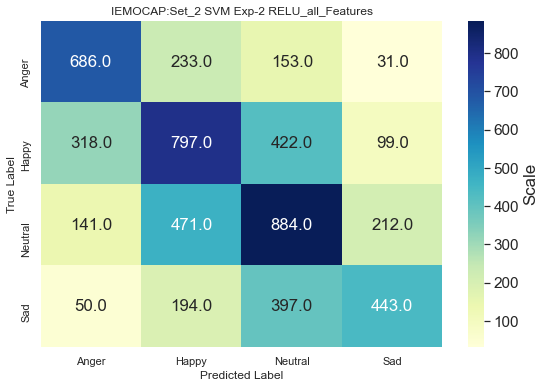

In [74]:
import seaborn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

conf_mat_data= confusion_matrix(tru_lab, pre_lab)
labels = ['Anger', 'Happy', 'Neutral', 'Sad']
seaborn.set(color_codes=True)
plt.figure(1, figsize=(9,6))
plt.title (title)
seaborn.set(font_scale=1.4)
ax=seaborn.heatmap(conf_mat_data, annot=True, cmap='YlGnBu', cbar_kws={'label':'Scale'}, fmt='.1f')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.set(ylabel='True Label', xlabel='Predicted Label')
plt.savefig("/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/"+Set+"/Exp_2/"+Embedding_type+"/SVM_"+Set+"_exp2_"+feat+".png",bbox_inches='tight', dpi=300)

In [104]:
CF_f1 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/CF_Set0_f1.mat"
f_f1= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/f_Set0_f1.mat"
CF_f2 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/CF_Set0_f2.mat"
f_f2= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/f_Set0_f2.mat"

CF_f3 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/CF_Set0_f3.mat"
f_f3= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/f_Set0_f3.mat"
CF_f4 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/CF_Set0_f4.mat"
f_f4= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/f_Set0_f4.mat"

CF_f5 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/CF_Set0_f5.mat"
f_f5= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/f_Set0_f5.mat"


In [105]:
import scipy.io

In [106]:
f1_CF= scipy.io.loadmat(CF_f1)['CF']
f1_f= scipy.io.loadmat(f_f1)['f']
f2_CF= scipy.io.loadmat(CF_f2)['CF']
f2_f= scipy.io.loadmat(f_f2)['f']

f3_CF= scipy.io.loadmat(CF_f3)['CF']
f3_f= scipy.io.loadmat(f_f3)['f']
f4_CF= scipy.io.loadmat(CF_f4)['CF']
f4_f= scipy.io.loadmat(f_f4)['f']

f5_CF= scipy.io.loadmat(CF_f5)['CF']
f5_f= scipy.io.loadmat(f_f5)['f']

print(f1_CF.shape, f1_f.shape)

(513, 1) (1, 513)


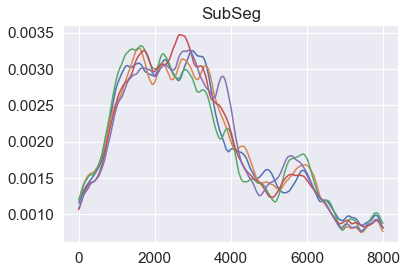

In [107]:
plt.plot (f1_f[0], f1_CF[:,0])
plt.plot (f2_f[0], f2_CF[:,0])
plt.plot (f3_f[0], f3_CF[:,0])
plt.plot (f4_f[0], f4_CF[:,0])
plt.plot (f5_f[0], f5_CF[:,0])
plt.title ("SubSeg")
plt.savefig("/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_0/Exp_2/SubSeg.png", dpi=300)

In [108]:
CF_f1 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/CF_Set2_f1.mat"
f_f1= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/f_Set2_f1.mat"
CF_f2 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/CF_Set2_f2.mat"
f_f2= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/f_Set2_f2.mat"

CF_f3 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/CF_Set2_f3.mat"
f_f3= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/f_Set2_f3.mat"
CF_f4 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/CF_Set2_f4.mat"
f_f4= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/f_Set2_f4.mat"

CF_f5 = "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/CF_Set2_f5.mat"
f_f5= "/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/f_Set2_f5.mat"

f1_CF= scipy.io.loadmat(CF_f1)['CF']
f1_f= scipy.io.loadmat(f_f1)['f']
f2_CF= scipy.io.loadmat(CF_f2)['CF']
f2_f= scipy.io.loadmat(f_f2)['f']

f3_CF= scipy.io.loadmat(CF_f3)['CF']
f3_f= scipy.io.loadmat(f_f3)['f']
f4_CF= scipy.io.loadmat(CF_f4)['CF']
f4_f= scipy.io.loadmat(f_f4)['f']

f5_CF= scipy.io.loadmat(CF_f5)['CF']
f5_f= scipy.io.loadmat(f_f5)['f']

print(f1_CF.shape, f1_f.shape)

(513, 1) (1, 513)


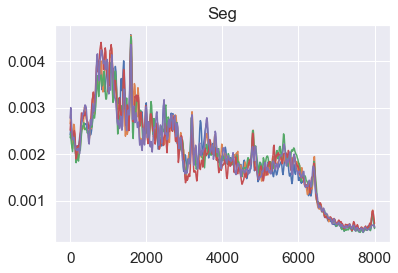

In [109]:
plt.plot (f1_f[0], f1_CF[:,0])
plt.plot (f2_f[0], f2_CF[:,0])
plt.plot (f3_f[0], f3_CF[:,0])
plt.plot (f4_f[0], f4_CF[:,0])
plt.plot (f5_f[0], f5_CF[:,0])
plt.title ("Seg")
plt.savefig("/idiap/temp/tpurohit/ICASSP2022/Julian_Codes/raw_cnn/Set_2/Exp_2/Seg.png", dpi=300)